<a href="https://colab.research.google.com/github/nipetrov/Homework-ML/blob/master/MLatFIAN2020_seminar05_QualityMetricsAndCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quality metrics for classification

## Confusion matrix

**TP** = true positive

**FP** = false positive

**TN** = true negative

**FN** = false negative

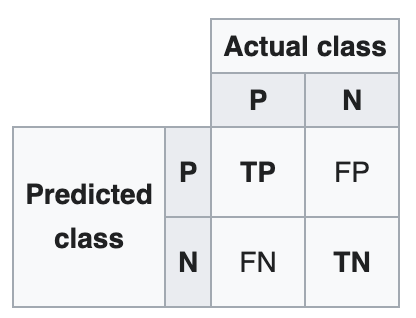

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm, trange

cmap = mpl.colors.ListedColormap(['#992622', '#005AAA'])

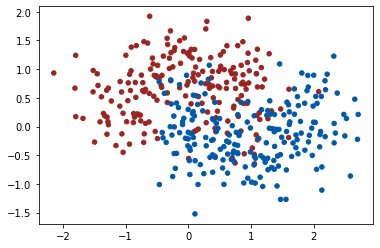

In [ ]:
def gen_dataset(n_positive, n_negative):
  outer_circ_x = np.cos(np.linspace(0, np.pi, n_negative))
  outer_circ_y = np.sin(np.linspace(0, np.pi, n_negative))
  inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_positive))
  inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_positive)) - .5

  X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                 np.append(outer_circ_y, inner_circ_y)]).T
  y = np.hstack([np.zeros(n_negative, dtype=np.intp),
                 np.ones(n_positive, dtype=np.intp)])

  X += np.random.normal(scale=0.4, size=X.shape)

  return X, y

X, y = gen_dataset(200, 200)
plt.scatter(*X.T, c=y, s=20, cmap=cmap);

In [ ]:
def plot_prediction(model, nx=100, ny=100, xmin=-2.5, xmax=3.5, ymin=-2.5, ymax=2.5):
  xx, yy = np.meshgrid(
      np.linspace(xmin, xmax, nx),
      np.linspace(ymin, ymax, ny)
  )

  preds = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0].reshape(xx.shape)
  plt.contour(xx, yy, preds, levels=[0.5], colors='k', linewidths=3)

## Exercise 1: plotting TP, FP, TN and FN

Modify the code below to distinguish true positives, false positives, true negatives and false negatives on the plot. Add legend.

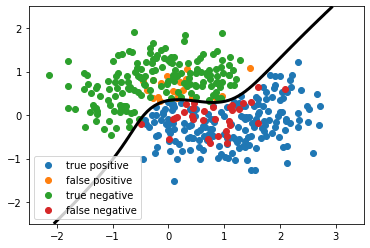

In [ ]:
model = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(3, include_bias=False),
    LogisticRegression()
)

model.fit(X, y)
plot_prediction(model)
y_pred = model.predict(X)
plt.scatter(*X[(y == 1) & (y_pred == 1)].T ,label = "true positive")
plt.scatter(*X[(y == 1) & (y_pred == 0)].T ,label = "false positive")
plt.scatter(*X[(y == 0) & (y_pred == 0)].T ,label = "true negative")
plt.scatter(*X[(y == 0) & (y_pred == 1)].T ,label = "false negative")
plt.legend()

## Exercise 2: accuracy, precision, recall, F1 score

$$\text{accuracy}=\frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

$$\text{precision}=\frac{\text{TP}}{\text{TP} + \text{FP}}$$

$$\text{recall}=\frac{\text{TP}}{\text{TP} + \text{FN}}$$

$$F_1=\frac{2\cdot\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}}$$

Implement the calculation of quality metrics in the function below.

In [ ]:
def calculate_metrics(y_true, y_pred):
  '''
  Function to calculate quality metrics.
  
  arguments:
   - y_true - numpy array of true labels (0 - negative class, 1 - positive class)
   - y_pred - numpy array of model predictions (0 - negative class, 1 - positive class)

  returns a tuple containing the calculated metrics:
    `(accuracy, precision, recall, f1)`
  '''

  # YOUR CODE: use only numpy operations to calculate the metrics
  accuracy = (y_true*y_pred + (1 - y_true)*(1 - y_pred)).mean()
  precision = (y_true*y_pred).sum()/y_pred.sum()
  recall = (y_true*y_pred).sum()/y_true.sum()
  f1 = 2*precision*recall/(precision + recall)
  return (accuracy, precision, recall, f1)


# Automatic checks:
import sklearn.metrics as skmetrics

dummy_y_true = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0])
dummy_y_pred = np.array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])

dummy_accuracy, dummy_precision, dummy_recall, dummy_f1 = \
  calculate_metrics(dummy_y_true, dummy_y_pred)
assert dummy_accuracy == skmetrics.accuracy_score(dummy_y_true, dummy_y_pred), 'Wrong accuracy'
assert dummy_precision == skmetrics.precision_score(dummy_y_true, dummy_y_pred), 'Wrong precision'
assert dummy_recall == skmetrics.recall_score(dummy_y_true, dummy_y_pred), 'Wrong recall'
assert dummy_f1 == skmetrics.f1_score(dummy_y_true, dummy_y_pred), 'Wrong F1 score'
print("All good!")

All good!


## Exercise 3: metrics as the function of class imbalance

Let's see how the metrics above behave when the classes are imbalanced.

For each $\alpha$ in `pos_class_fractions` below generate train and test datasets with $N = 50000$ points each, such that `n_positive`$ = \alpha N$, `n_negative`$ = (1 - \alpha)N$ (**don't foget to round and convert these numbers to integers!**). Train and evaluate the model on the generated data, plot test metrics (accuracy, precision, recall and F1) as a function of $\alpha$ on the same plot.

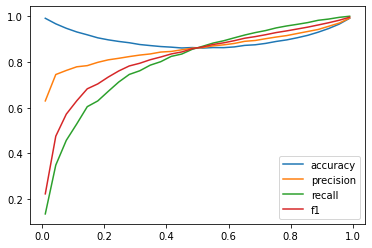

In [ ]:
pos_class_fractions = np.linspace(0.01, 0.99, 30)
accuracy = []
precision = []
recall = []
f1 = []
for a in pos_class_fractions : 
  n_positive = int(np.round(50000*a))
  n_negative = 50000 - n_positive
  X_train, y_train = gen_dataset(n_positive, n_negative)
  X_test, y_test = gen_dataset(n_positive, n_negative)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  ac, pr, rec, f = calculate_metrics(y_test, y_pred)
  accuracy.append(ac)
  precision.append(pr)
  recall.append(rec)
  f1.append(f)
plt.plot(pos_class_fractions, accuracy, label = 'accuracy')
plt.plot(pos_class_fractions, precision, label = 'precision')
plt.plot(pos_class_fractions, recall, label = 'recall')
plt.plot(pos_class_fractions, f1, label = 'f1')
plt.legend()



## ROC curve

For a given model that gives the positive class score with $\hat{f}(x)$, prediction is obtained by thresholding this score with some threshold $T$:

$$\hat{y} = \mathbb{I}\left\{\hat{f}(x) \geq T\right\}$$

Then, true and false positive rates can be defined as functions of threshold.

True positive rate:
$$\text{TPR}(T) = \frac{\text{TP}(T)}{\text{TP}(T) + \text{FN}(T)}$$

False positive rate:
$$\text{FPR}(T) = \frac{\text{FP}(T)}{\text{FP}(T) + \text{TN}(T)}$$

ROC curve - TPR as a function of FPR.

Check out this nice demo: http://arogozhnikov.github.io/2015/10/05/roc-curve.html

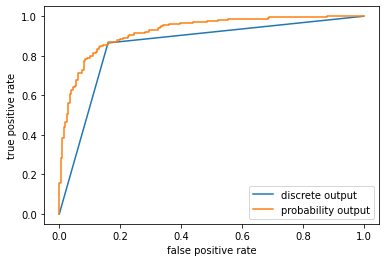

In [ ]:
X_train, y_train = gen_dataset(200, 200)
X_test, y_test = gen_dataset(200, 200)

model = make_pipeline(
    RobustScaler(),
    PolynomialFeatures(3, include_bias=False),
    LogisticRegression()
)

model.fit(X_train, y_train)
preds_test = model.predict(X_test)
proba_test = model.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, preds_test)
plt.plot(fpr, tpr, label='discrete output');
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.plot(fpr, tpr, label='probability output');
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate');

Another metric - area under the ROC curve ("ROC AUC", or sometimes just "AUC").

 - AUC = 1.0 – perfect classification
 - AUC = 0.5 – random guess (worst classification)
 - AUC = 0.0 – perfect misclassification (converts to perfect classification by swapping the labels $1\leftrightarrow 0$)

In [ ]:
from sklearn.metrics import roc_auc_score

print('AUC (discrete):', roc_auc_score(y_test, preds_test))
print('AUC (probability):', roc_auc_score(y_test, proba_test))

AUC (discrete): 0.8525
AUC (probability): 0.9233


# Cross-validation

For more details: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

To avoid overfitting, we typically leave a part of our data held out as the **test set**, to check the performance of a trained model on it:

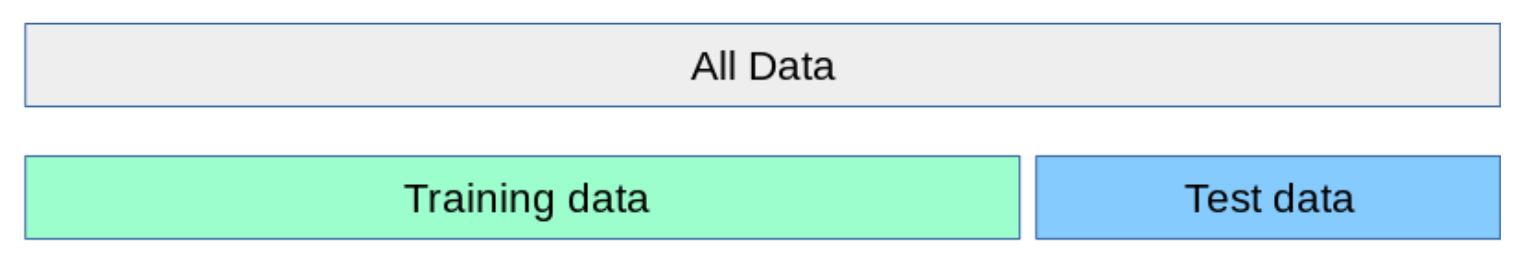

But if we use the test set to tune our parameters on it, we may "overfit to the test set". That is, the estimate of the model performance quality on that same test set would be biased.

An alternative approach would be to split the data into 3 parts:
 - **train** – to train the model on
 - **validation** – to evaluate the performance during hyperparameter tuning, and
 - **test** – to evalueate the performance of the final model

This, however, with this approach we drastically reduce the number of samples to be used to train the model.

An alternative approach is called Cross-validation (CV):

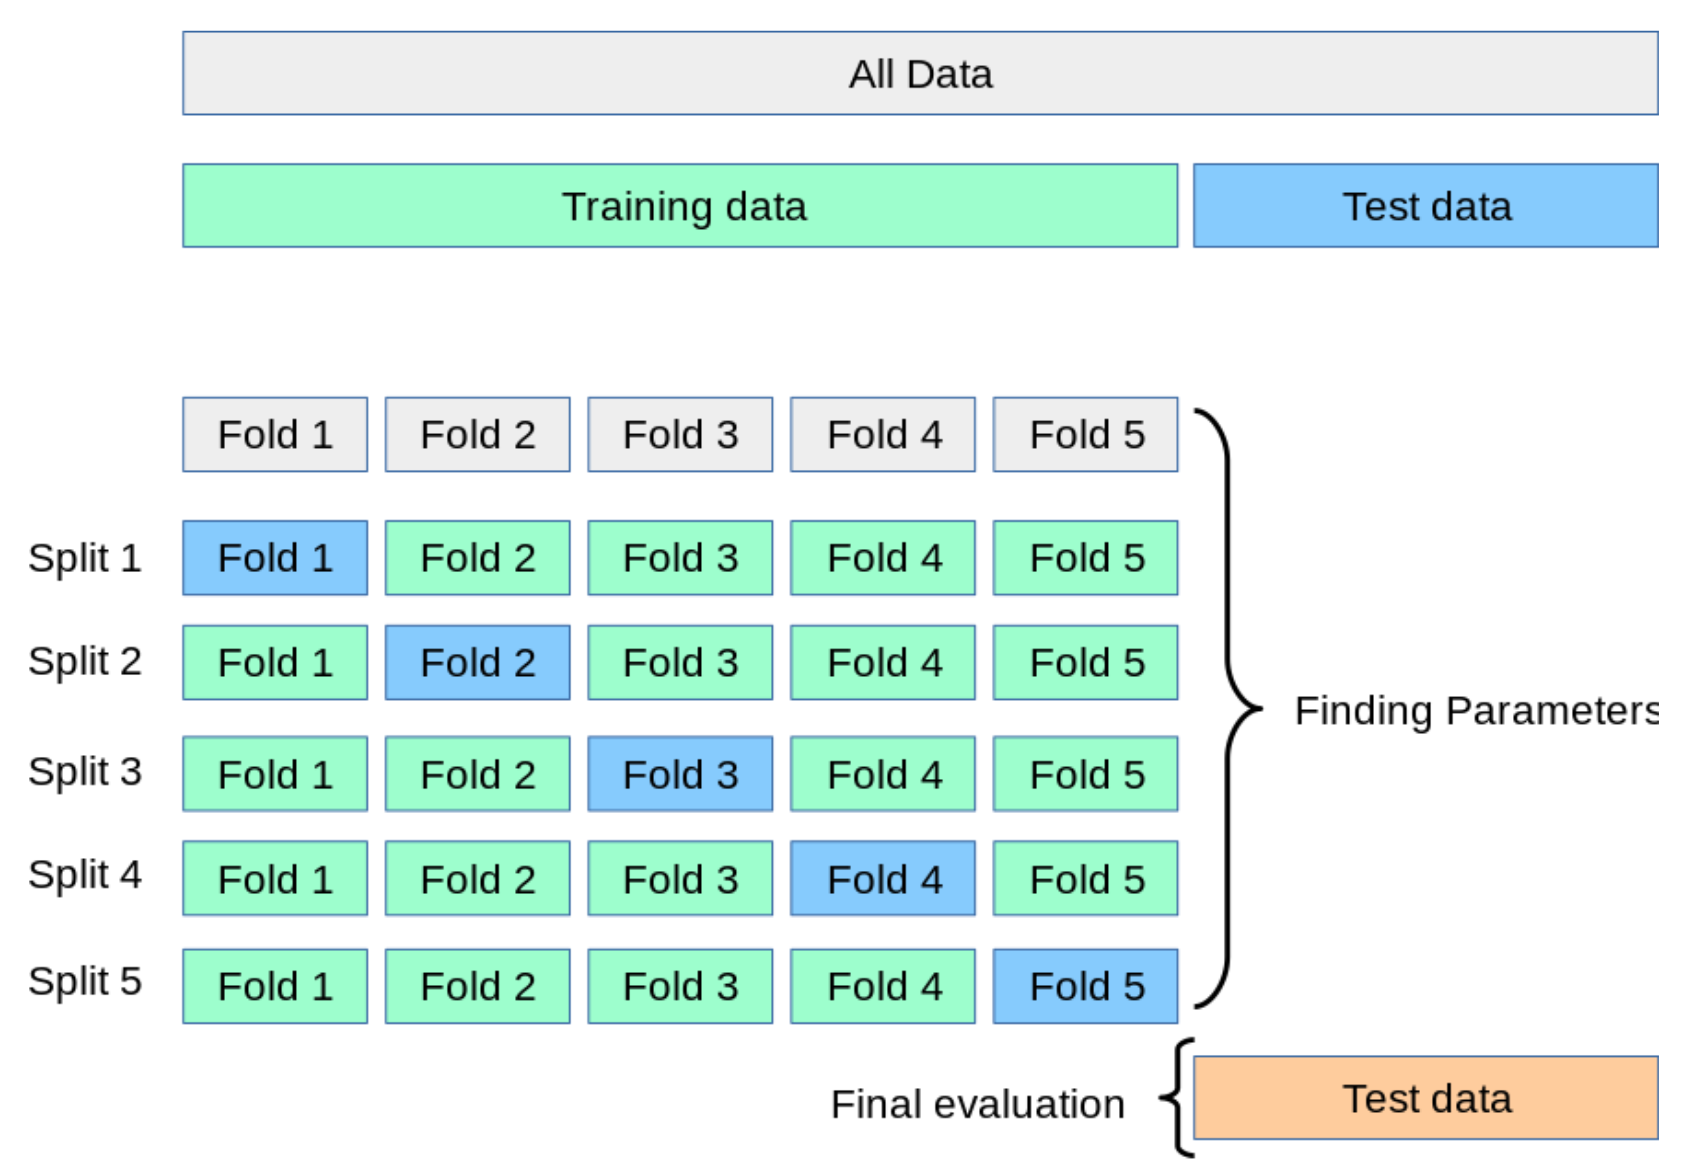

Example:

mean = 0.9237857142857143, std = 0.0636423226956342


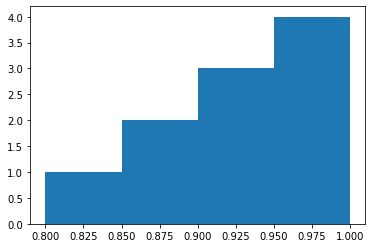

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

X, y = gen_dataset(50, 50)

kf = KFold(n_splits=10, shuffle=True)
roc = []
for i_train, i_test in kf.split(X):
  X_train = X[i_train]
  y_train = y[i_train]
  X_test = X[i_test]
  y_test = y[i_test]
  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)[:,1]
  roc.append(roc_auc_score(y_test, y_pred))
#  roc.append(roc_auc_score)
plt.hist(roc, bins = 4)
nproc = np.array(roc)
print(f"mean = {nproc.mean()}, std = {nproc.std()}")


Complete the code above to evaluate the performance of the model (using ROC AUC). Increase the number of objects in the original dataset to 50 positives + 50 negatives.

Calculate the mean and standard deviation of test ROC AUC estimates on the different folds, plot the histogram of test ROC AUC values on different folds.

## Grid search CV

In [ ]:
def plotting(param, score, score_error):
    plt.figure(figsize=(12, 5))
    plt.title("ROC_AUC score")
    plt.xlabel('param_value')
    plt.ylabel('ROC_AUC score')
    plt.plot(param, score,'o-', color='b', ms=5, label="ROC_AUC score")
    plt.fill_between(param,
                     score - 1.96 * score_error,
                     score + 1.96 * score_error,
                     facecolor='g', alpha=0.6, label="95% confidence interval")
    plt.legend()
    plt.grid()

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

X, y = gen_dataset(50, 50)

base_model = make_pipeline(
  RobustScaler(),
  SVC(kernel='rbf')
)

param_grid = {'svc__gamma': np.logspace(-2, 2, 41, base=10)}

gscv = GridSearchCV(base_model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

gscv.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('robustscaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                   

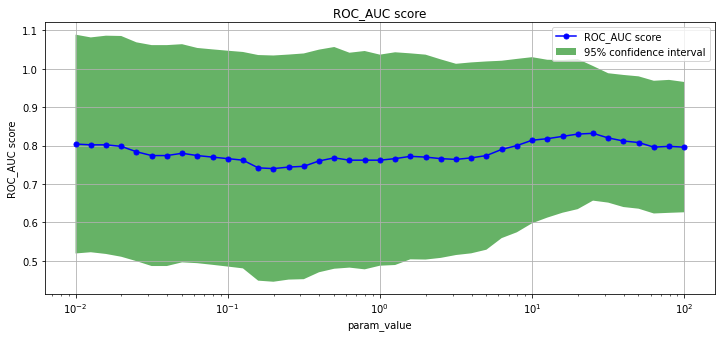

In [ ]:
plotting(gscv.param_grid['svc__gamma'],
         gscv.cv_results_['mean_test_score'],
         gscv.cv_results_['std_test_score'] / (gscv.cv - 1)**0.5)
plt.xscale('log');